In [34]:
# ==========================================
# PART 1: SETUP & DATA LOADING
# ==========================================
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10
IMG_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Cloning Repository
repo_url = "https://github.com/TahsinArafat/Geometric-Shapes-Classification-CNN.git"
repo_name = "Geometric-Shapes-Classification-CNN"

if not os.path.exists(repo_name):
    print(f"Cloning {repo_url}...")
    !git clone $repo_url
else:
    print("Repo already exists. Pulling latest...")
    !cd $repo_name && git pull

# 2. Paths
TRAIN_DIR = os.path.join(repo_name, 'training', 'train')
VAL_DIR = os.path.join(repo_name, 'training', 'validation')
TEST_DIR = os.path.join(repo_name, 'training', 'test')
CUSTOM_DIR = os.path.join(repo_name, 'dataset')  # For Phone Task

# 3. Data Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 4. Loading Data
print(f"Loading training data from: {TRAIN_DIR}")
if not os.path.exists(TRAIN_DIR):
    print(f"ERROR: Could not find {TRAIN_DIR}. Check your repo structure!")
else:
    train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
    val_dataset = torchvision.datasets.ImageFolder(root=VAL_DIR, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=TEST_DIR, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Classes found: {train_dataset.classes}")

Using device: cuda
Repo already exists. Pulling latest...
Already up to date.
Loading training data from: Geometric-Shapes-Classification-CNN/training/train
Classes found: ['circles', 'squares', 'triangles']


In [35]:
# ==========================================
# PART 2: CNN MODEL ARCHITECTURE
# ==========================================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Layer 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Input 64x64 -> Pool(2) -> 32x32 -> Pool(2) -> 16x16
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3) # 3 Classes (Circle, Square, Triangle)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16) # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [36]:
# ==========================================
# PART 3: TRAINING LOOP
# ==========================================
train_losses, val_losses = [], []
train_accs, val_accs = [], []

if 'train_loader' in locals():
    print("Starting training...")
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_losses.append(val_running_loss / len(val_loader))
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{EPOCHS}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), 'geometric_cnn.pth')
    print("Model saved as geometric_cnn.pth")


Starting training...
Epoch [1/10], Train Acc: 51.38%, Val Acc: 43.33%
Epoch [2/10], Train Acc: 63.17%, Val Acc: 53.89%
Epoch [3/10], Train Acc: 71.09%, Val Acc: 57.22%
Epoch [4/10], Train Acc: 76.24%, Val Acc: 63.33%
Epoch [5/10], Train Acc: 78.82%, Val Acc: 65.00%
Epoch [6/10], Train Acc: 79.01%, Val Acc: 72.22%
Epoch [7/10], Train Acc: 82.69%, Val Acc: 77.78%
Epoch [8/10], Train Acc: 85.45%, Val Acc: 81.67%
Epoch [9/10], Train Acc: 88.40%, Val Acc: 84.44%
Epoch [10/10], Train Acc: 91.53%, Val Acc: 83.89%
Model saved as geometric_cnn.pth


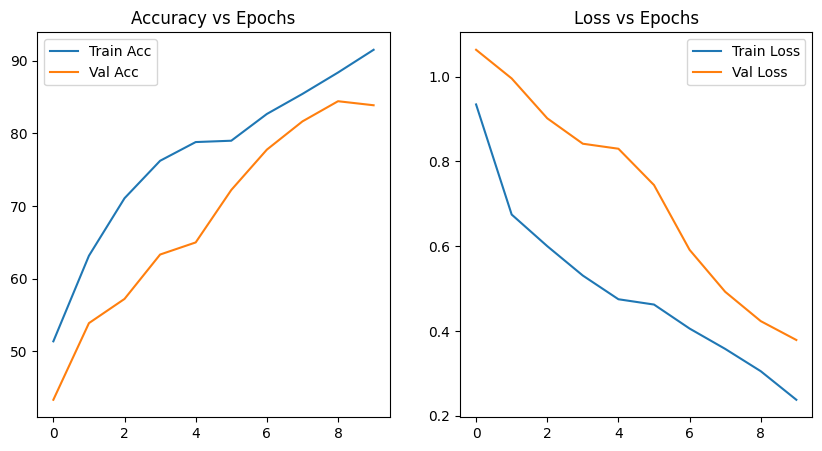

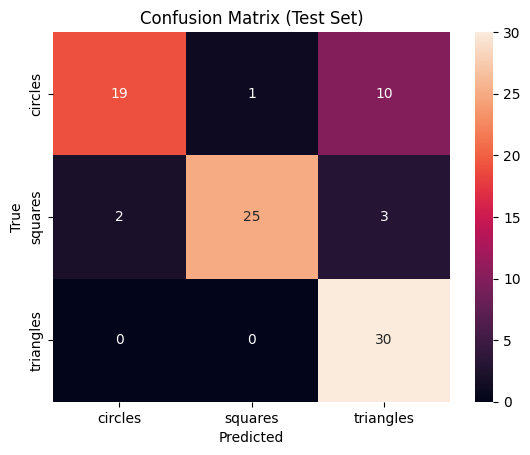

In [37]:
# ==========================================
# PART 4: VISUALS & CONFUSION MATRIX
# ==========================================
if 'train_losses' in locals() and len(train_losses) > 0:
    # Training Plots
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Confusion Matrix (Using 'test' folder)
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title("Confusion Matrix (Test Set)")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()



--- Checking for Custom Phone Images in Geometric-Shapes-Classification-CNN/dataset ---


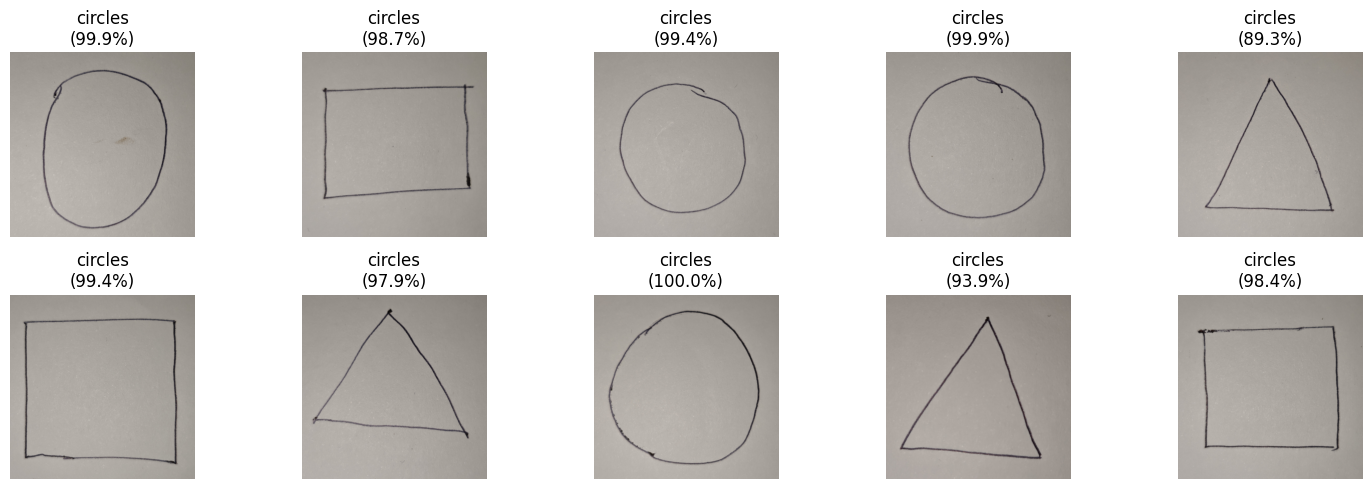

In [38]:
# ==========================================
# PART 5: CUSTOM PHONE IMAGE PREDICTIONS
# ==========================================
print(f"\n--- Checking for Custom Phone Images in {CUSTOM_DIR} ---")

if os.path.exists(CUSTOM_DIR):
    custom_images = [f for f in os.listdir(CUSTOM_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(custom_images) > 0:
        plt.figure(figsize=(15, 5))
        for i, img_name in enumerate(custom_images[:10]): # Limit to 10
            img_path = os.path.join(CUSTOM_DIR, img_name)
            image = Image.open(img_path).convert('RGB')

            # Apply same transforms
            input_tensor = transform(image).unsqueeze(0).to(device)

            # Predict
            model.eval()
            with torch.no_grad():
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)
                conf, pred_idx = torch.max(probs, 1)

            pred_class = train_dataset.classes[pred_idx.item()]
            confidence = conf.item() * 100

            plt.subplot(2, 5, i+1)
            plt.imshow(image)
            plt.title(f"{pred_class}\n({confidence:.1f}%)")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Folder is empty!")
else:
    print(f"'{CUSTOM_DIR}' folder not found.")


--- Visual Error Analysis (Incorrect Predictions) ---


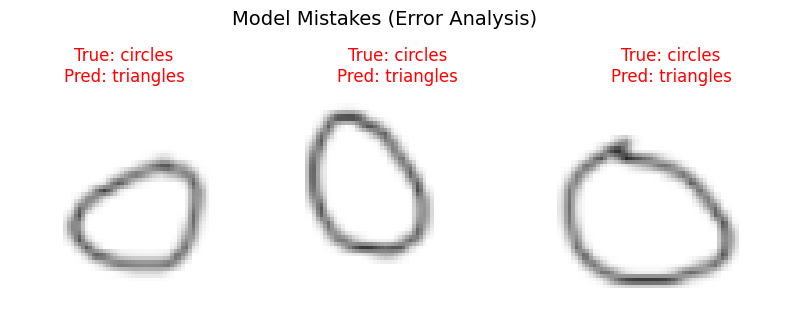

In [39]:
# ==========================================
# PART 6: VISUAL ERROR ANALYSIS
# ==========================================
print("\n--- Visual Error Analysis (Incorrect Predictions) ---")

model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        wrong_idx = (predicted != labels).nonzero()

        for idx in wrong_idx:
            if len(misclassified_images) < 3:
                index = idx.item()
                # Denormalize image for display (reverse the 0.5 mean/std)
                img = images[index].cpu() * 0.5 + 0.5
                misclassified_images.append(img)
                misclassified_labels.append(labels[index].item())
                misclassified_preds.append(predicted[index].item())
            else:
                break
        if len(misclassified_images) >= 3:
            break

if len(misclassified_images) > 0:
    plt.figure(figsize=(10, 4))
    for i in range(len(misclassified_images)):
        plt.subplot(1, 3, i+1)
        plt.imshow(misclassified_images[i].permute(1, 2, 0)) # Convert (C,H,W) -> (H,W,C)
        true_cls = train_dataset.classes[misclassified_labels[i]]
        pred_cls = train_dataset.classes[misclassified_preds[i]]
        plt.title(f"True: {true_cls}\nPred: {pred_cls}", color='red')
        plt.axis('off')
    plt.suptitle("Model Mistakes (Error Analysis)", fontsize=14)
    plt.show()
else:
    print("No mistake!")